# Relative Diffusivity

## Generating the Network, adding Geometry and creating Phases

This example shows you how to calculate a transport property relative to the saturation of the domain by a particular phase. In this case the property is the diffusivity of air relative to the saturation of water. Start by importing OpenPNM and some other useful packages:

In [1]:
import numpy as np
import openpnm as op
import matplotlib.pyplot as plt
%matplotlib inline
ws = op.Workspace()
np.random.seed(10)
ws.settings["loglevel"] = 40
np.set_printoptions(precision=5)

Next create a **Network** object with a cubic topology and lattice spacing of 25 microns and add boundary pores

In [2]:
pn = op.network.Cubic(shape=[20, 20, 20], spacing=25e-6)

Next create a **Geometry** to manage the pore and throat size information.  A **Geometry** can span over a part of the **Network** only, so we need to specify to which pores and throats this **Geometry** object should apply. 

In [3]:
geom = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)

The ``StickAndBall`` **Geometry** is a predefined class that applies randomly distributed pore and throat sizes to the internal pores. The ``Boundary`` class is predefined with properties suitable for boundaries such as 0 volume and length.  

We must also create the **Phase** objects, for our purposes the standard ``air`` and ``water`` phase classes provided are fine:

In [4]:
air = op.phases.Air(network=pn, name='air')
water = op.phases.Water(network=pn, name='water')

## Define the Pore-Scale Physics

For this simulation the **Standard** physics object can be used as it contains capillary pressure for use in the percolation algorithm and diffusive conductance for use in the ``FickianDiffusion`` algorithm.

In [5]:
phys_air = op.physics.Standard(network=pn, phase=air, geometry=geom)
phys_water = op.physics.Standard(network=pn, phase=water, geometry=geom)

## Set up and run the Percolation Algorithm
In order to simulate a partially saturated material we first invade some non-wetting phase.  This will be accomplished using the ``InvasonPercolation`` **Algorithm** which invades the network with an invading phase based on the capillary pressure of the throats in the network. This gives us the sequence at which pores and throats are invaded.  

In [6]:
OP_1 = op.algorithms.OrdinaryPercolation(network=pn)
OP_1.setup(phase=water, pore_volume='pore.volume', throat_volume='throat.volume')
OP_1.set_inlets(pn.pores('back'))
OP_1.run()

Here we have selected half of the boundary pores at the bottom of the domain as inlets for the percolation **Algorithm**. ``OrdinaryPercolation`` has a helpful plotting function which displays the saturation of the invading phase (volume fraction of the pore space) vs. capillary pressure:

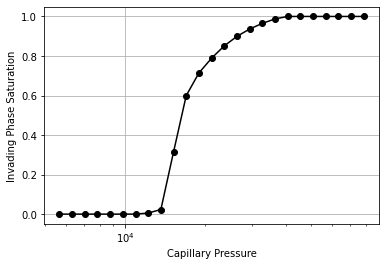

In [7]:
# NBVAL_IGNORE_OUTPUT
import numpy as np
fig = OP_1.plot_intrusion_curve()

Let's look at the raw data:

In [8]:
ax = fig.get_axes()[0]
Pc = ax.lines[0].get_xdata()
Sat = ax.lines[0].get_ydata()
print(f"Capillary pressure (Pa): {Pc}")
print(f"Invading phase saturation: {Sat}")

Capillary pressure (Pa): [ 5654.90289  6310.77113  7042.70843  7859.53744  8771.10411  9788.3963
 10923.67632 12190.62863 13604.5249  15182.40801 16943.29752 18908.41892
 21101.45947 23548.85376 26280.10229 29328.1271  32729.66863 36525.72852
 40762.0639  45489.73889 50765.74016 56653.66381 63224.48196 70557.39825
 78740.8025 ]
Invading phase saturation: [0.      0.      0.      0.      0.      0.      0.      0.00533 0.02335
 0.31475 0.59966 0.71406 0.78904 0.85109 0.89932 0.93632 0.96494 0.98731
 1.      1.      1.      1.      1.      1.      1.     ]


## Run a Fickian Diffusion Algorithm for each step of the invasion process

We now need to model how the presence of the phases affects the diffusive conductivity of the network. Currently the **Physics** objects have a property called ``throat.diffusive_conductance`` but this model does not account for the occupancy of each phase and assumes that the phase occupies every pore-throat-pore conduit. OpenPNM has a number of multiphase models including a conduit conductance that multiplies the single phase conductance by a factor (default 0.000001) when the phase associated with the physics object is not present. The model has a mode which defaults to 'strict' which applies the conductivity reduction if any one of the connected pores or connecting throat is unoccupied.

In [9]:
import openpnm.models.physics as pm
water.update(OP_1.results(Pc=10000))
air.update(OP_1.results(Pc=10000))
phys_air.add_model(model=pm.multiphase.conduit_conductance,
                   propname='throat.conduit_diffusive_conductance',
                   throat_conductance='throat.diffusive_conductance')
phys_water.add_model(model=pm.multiphase.conduit_conductance,
                     propname='throat.conduit_diffusive_conductance',
                     throat_conductance='throat.diffusive_conductance')

Now for each invasion step we cycle through the principle directions and create ``FickianDiffusion`` objects for each phase and calculate the effective diffusivity.  First we create some variables to store our data in for each principle direction (x, y, z). The boundary planes at each side of the domain are used as boundary pores for the Diffusion algorithm.  

In [10]:
bounds = [['front', 'back'], ['left', 'right'], ['top', 'bottom']]
diff_air = {'0': [], '1': [], '2': []}
diff_water = {'0': [], '1': [], '2': []}
sat= []
tot_vol = np.sum(pn["pore.volume"]) + np.sum(pn["throat.volume"])
for Pc in np.unique(OP_1['pore.invasion_pressure']):
    water.update(OP_1.results(Pc=Pc))
    air['pore.occupancy'] = 1 - water['pore.occupancy']
    air['throat.occupancy'] = 1 - water['throat.occupancy']
    phys_air.regenerate_models()
    phys_water.regenerate_models()
    this_sat = 0
    this_sat += np.sum(pn["pore.volume"][water["pore.occupancy"] == 1])
    this_sat += np.sum(pn["throat.volume"][water["throat.occupancy"] == 1])
    sat.append(this_sat)
    for bound_increment in range(len(bounds)):
        BC1_pores = pn.pores(labels=bounds[bound_increment][0])
        BC2_pores = pn.pores(labels=bounds[bound_increment][1])
        FD_1 = op.algorithms.FickianDiffusion(network=pn)
        FD_1.setup(phase=air, conductance='throat.conduit_diffusive_conductance')
        FD_1.set_value_BC(values=0.6, pores=BC1_pores)
        FD_1.set_value_BC(values=0.2, pores=BC2_pores)
        FD_1.run()
        eff_diff = FD_1.calc_effective_diffusivity(domain_area=2.5e-3, domain_length=0.25e-3)
        diff_air[str(bound_increment)].append(eff_diff)
        FD_2 = op.algorithms.FickianDiffusion(network=pn)
        FD_2.setup(phase=water, conductance='throat.conduit_diffusive_conductance')
        FD_2.set_value_BC(values=0.6, pores=BC1_pores)
        FD_2.set_value_BC(values=0.2, pores=BC2_pores)
        FD_2.run()
        eff_diff = FD_2.calc_effective_diffusivity(domain_area=2.5e-3, domain_length=0.25e-3)
        diff_water[str(bound_increment)].append(eff_diff)
        pn.project.purge_object(FD_1)
        pn.project.purge_object(FD_2)

The ```results``` method updates the two **Phase** objects with the occupancy at the given capillary pressure (Pc). The **Physics** objects are then regenerated to re-calculate the ```conduit_diffusive_conductance``` property.

> **Note** :  Six Diffusion algorithm objects could have been created outside the loop and then run over and over with the updated conductance values and this would possibly save some computational time.

## Plot the Relative Diffusivity Curves for each direction and Phase

Now tidy up the data converting them into Numpy arrays for easy plotting and manipulation and normalize the results by the single phase values:

In [11]:
sat = np.asarray(sat)
sat /= tot_vol
rel_diff_air_x    =  np.asarray(diff_air['0'])
rel_diff_air_x   /=  rel_diff_air_x[0]
rel_diff_air_y    =  np.asarray(diff_air['1'])
rel_diff_air_y   /=  rel_diff_air_y[0]
rel_diff_air_z    =  np.asarray(diff_air['2'])
rel_diff_air_z   /=  rel_diff_air_z[0]
rel_diff_water_x  =  np.asarray(diff_water['0'])
rel_diff_water_x /=  rel_diff_water_x[-1]
rel_diff_water_y  =  np.asarray(diff_water['1'])
rel_diff_water_y /=  rel_diff_water_y[-1]
rel_diff_water_z  =  np.asarray(diff_water['2'])
rel_diff_water_z /=  rel_diff_water_z[-1]

Finally plot the results:

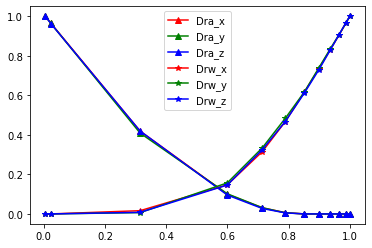

In [12]:
# NBVAL_IGNORE_OUTPUT
plots = []
plots.append(plt.plot(sat, rel_diff_air_x, '^-r', label='Dra_x'))
plots.append(plt.plot(sat, rel_diff_air_y, '^-g', label='Dra_y'))
plots.append(plt.plot(sat, rel_diff_air_z, '^-b', label='Dra_z'))
plots.append(plt.plot(sat, rel_diff_water_x, '*-r', label='Drw_x'))
plots.append(plt.plot(sat, rel_diff_water_y, '*-g', label='Drw_y'))
plots.append(plt.plot(sat, rel_diff_water_z, '*-b', label='Drw_z'))
plt.legend();